# Media Matters Worldwide Bayesian Media Mix Model

This notebook contains a media mix model, created from methods similar to __[this paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46001.pdf)__. The model informs a budget optimizer, which optimizes the budget for spending in advertising media channels in the short-term.

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score 
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from datetime import datetime as dt
from functools import reduce
from yellowbrick.regressor import residuals_plot
from transformations import transform_one_column, select_best_feature, feature_imp_random_forest

import time
import datetime
import ipywidgets as widgets
from ipywidgets import FileUpload

from IPython.display import display
from IPython.display import FileLink
import io
import re
from scipy.optimize import minimize, LinearConstraint

import openpyxl
import xlrd

import holidays

from helper import *
from bayesian import *

import panel as pn
pn.extension()

***

<a id="data-collection"></a> 
# Data Collection

### your inputs start

In [4]:
client = "Proactiv"
use_excel = True
granularity = True # TRUE CORRESPONDS TO DAILY
data_type = "SALES DATA"
sales_fileName = "Proactiv_OrderData_2022.03.23.xlsx" # TYPE THE FILE NAME OF THE SALES DATA
ad_fileName = "Proactiv_MediaData_2022.03.23.xlsx"# TYPE THE FILE NAME OF THE MEDIA DATA

### your inputs end

In [3]:
if use_excel:
    sales_df = pd.read_excel(sales_fileName)
else:
    sales_df = pd.read_csv(sales_fileName)

In [4]:
sales_df_cleaned = clean_sales(sales_df, data_type, granularity=granularity)

COLUMNS of SALES DATA: ['Campaign Geo' 'Day' 'Visits' 'Orders' 'Conv Rate (Adobe)'
 'Revenue (Adobe)']


COUNTRY | [column-name/NONE] Campaign Geo
DAY | [column-name] Day
RESPONSE VARIABLE | [column-name] Orders


This process will be repeated for the advertising media mix data.

In [5]:
if use_excel:
    ad_df = pd.read_excel(ad_fileName)
else:
    ad_df = pd.read_csv(ad_fileName)

In [6]:
data_dict = clean_and_merge(ad_df, sales_df_cleaned)
for key in data_dict:
    data_dict[key].columns = [re.sub('[^0-9a-zA-Z_=.]+', '', col) for col in data_dict[key].columns]

['Day' 'Campaign Geo' 'Channel' 'Publisher' 'Media Objective' 'Audience'
 'Ad Type' 'Media Cost' 'Impressions']


COUNTRY? Campaign Geo
MEDIA COST? Media Cost
IMPRESSIONS? Impressions


***

# Modeling

### your inputs start

In [5]:
country = "US"
target = 'Orders'

In [8]:
df = data_dict[country]

In [9]:
dfMediaCombined = pd.DataFrame()
fringe = set([])
cols = sorted(df.columns.values)
for col in get_media_vars(df):
    short = shorten_f_name(col)
    if short in fringe:
        dfMediaCombined[f"{short}_media_cost".lower()] += df[col]
    else:
        dfMediaCombined[f"{short}_media_cost".lower()] = df[col]
    fringe.add(col)

dfMediaCombined[target] = df[target]

In [10]:
dfMediaCombined.isna().sum()

amazon_media_cost          0
bingsearch_media_cost      0
ctv_media_cost             0
criteo_media_cost          0
dv360_media_cost           0
facebook_media_cost        0
googlesearch_media_cost    0
influential_media_cost     0
lineartv_media_cost        0
pinterest_media_cost       0
radio_media_cost           0
snapchat_media_cost        0
thetradedesk_media_cost    0
tinder_media_cost          0
twitch_media_cost          0
youtube_media_cost         0
Orders                     0
dtype: int64

### your inputs end

In [6]:
dfMediaCombined = pd.read_csv("TEST_PREDICT_4_25.csv").set_index("Day")

In [7]:
initial_model = BayesianMixModel(country=country, target=target)
X = dfMediaCombined.drop(columns=[target])
y = dfMediaCombined[target]
xtrain, xval, ytrain, yval = train_test_split(X,y, test_size=0.2, shuffle=False)

In [8]:
initial_model.fit(xtrain, ytrain)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coef, noise, base, car_youtube_media_cost, sat_youtube_media_cost, coef_youtube_media_cost, car_twitch_media_cost, sat_twitch_media_cost, coef_twitch_media_cost, car_tinder_media_cost, sat_tinder_media_cost, coef_tinder_media_cost, car_thetradedesk_media_cost, sat_thetradedesk_media_cost, coef_thetradedesk_media_cost, car_snapchat_media_cost, sat_snapchat_media_cost, coef_snapchat_media_cost, car_radio_media_cost, sat_radio_media_cost, coef_radio_media_cost, car_pinterest_media_cost, sat_pinterest_media_cost, coef_pinterest_media_cost, car_lineartv_media_cost, sat_lineartv_media_cost, coef_lineartv_media_cost, car_influential_media_cost, sat_influential_media_cost, coef_influential_media_cost, car_googlesearch_media_cost, sat_googlesearch_media_cost, coef_googlesearch_media_cost, car_facebook_media_cost, sat_facebook_media_cost, coef_facebook_media_cost, car_dv3

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 1489 seconds.
There were 544 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6116166599456188, but should be close to 0.8. Try to increase the number of tuning steps.
There were 513 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6875221285519647, but should be close to 0.8. Try to increase the number of tuning steps.
There were 633 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5385122808681683, but should be close to 0.8. Try to increase the number of tuning steps.
There were 651 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6735694962919313, but should be clo

In [9]:
# trainPred = initial_model.predict(xtrain)
# mape(ytrain, trainPred)

In [10]:
# valPred = initial_model.predict(xval)

In [11]:
# mape(yval, valPred)
cs188, cs61c, data100, econ
cs61c, cs182, , data8

NameError: name 'cs188' is not defined

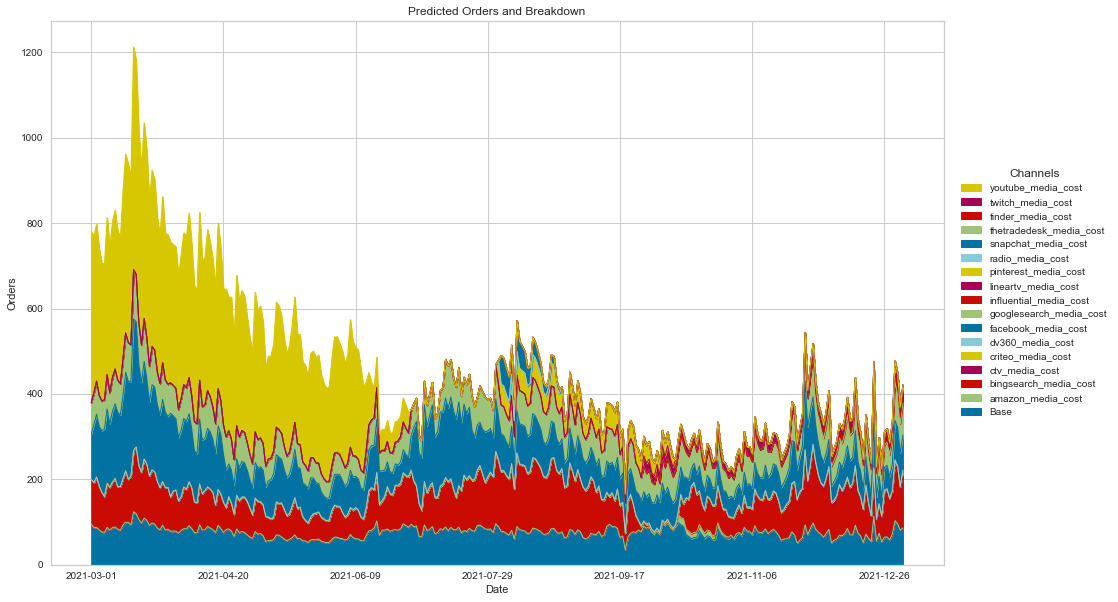

In [12]:
initial_model.attribution()

In [14]:
xtrain.sum(axis=0)

amazon_media_cost          9.475823e+02
bingsearch_media_cost      5.423770e+04
ctv_media_cost             1.859370e+05
criteo_media_cost          0.000000e+00
dv360_media_cost           2.708275e+05
facebook_media_cost        2.650663e+06
googlesearch_media_cost    1.304326e+06
influential_media_cost     5.143680e+04
lineartv_media_cost        8.680600e+05
pinterest_media_cost       2.158825e+04
radio_media_cost           0.000000e+00
snapchat_media_cost        9.576597e+02
thetradedesk_media_cost    0.000000e+00
tinder_media_cost          0.000000e+00
twitch_media_cost          0.000000e+00
youtube_media_cost         2.290543e+05
dtype: float64

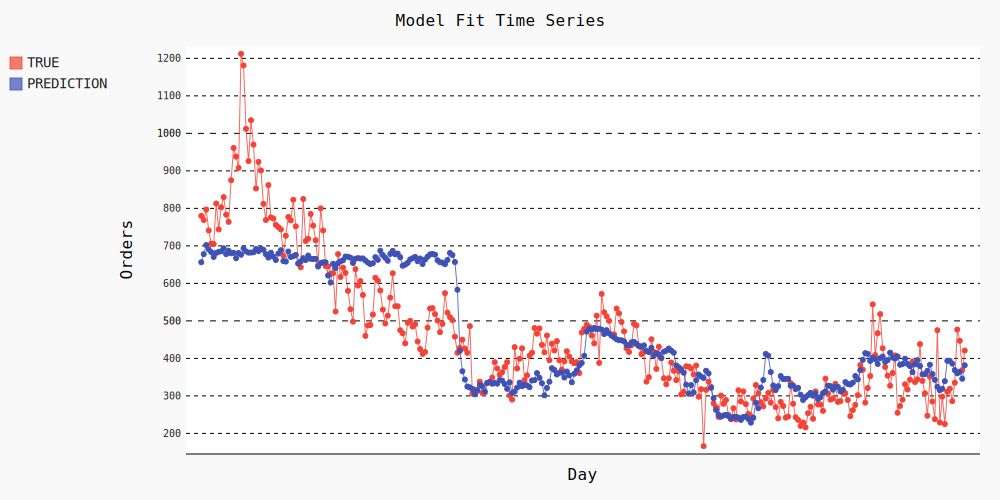

In [15]:
initial_model.lineplot()

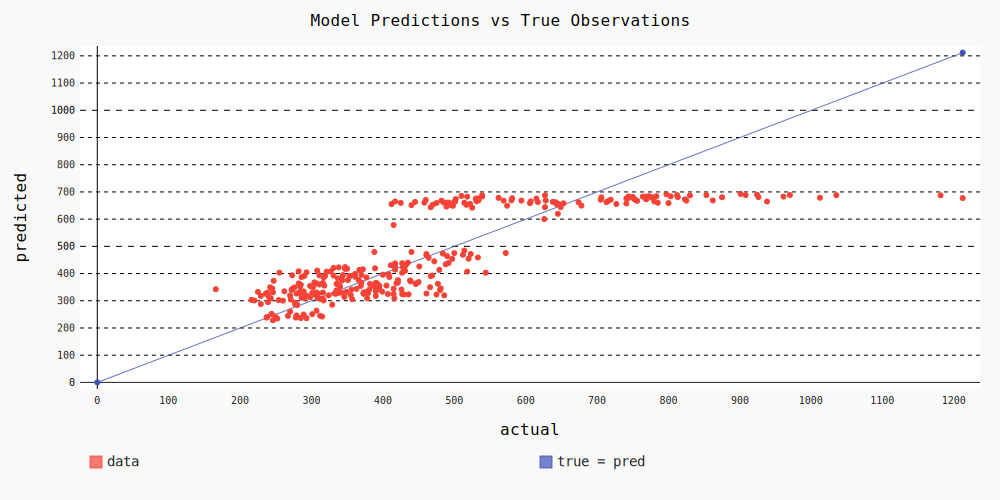

In [16]:
initial_model.scatterplot()

In [ ]:
plt.plot(np.arange(len(yval)), yval)

In [ ]:
with initial_model.mmm:
    pm.set_data({"data": xval}, model=initial_model.mmm)
    ppc_test = pm.sample_posterior_predictive(initial_model.trace, model=initial_model.mmm, samples=100)
    p_test_pred = ppc_test["sales"].mean(axis=0)

In [ ]:
len(p_test_pred)

# Forecasting

In [16]:
initial_model.trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [ ]:
X

In [46]:
X.columns

Index(['youtube_media_cost', 'googlesearch_media_cost', 'facebook_media_cost'], dtype='object')

To forecast for one-month (or any time length greater than 1 day), write an excel spreadsheet or .csv file with the above columns in that **EXACT** order. Set `use_excel` to `True` if the file is an excel file, else set it to `False`.

In [47]:
data_type = "ad data [forecasting]"
use_excel = True

In [48]:
forecast_as_bytes = input_file(data_type, use_excel=use_excel)

FileUpload(value={}, accept='.xlsx', description='Upload')

In [49]:
forecast_sales_df = parse_file(forecast_as_bytes, data_type, use_excel=use_excel)

AssertionError: PLEASE go back and run the above CELL

In [55]:
forecast_sales_df = forecast_sales_df.iloc[:, np.arange(len(get_media_vars(x)))]
forecast_sales_df.columns = get_media_vars(x)

In [56]:
forecast_output_df = month_predict(forecast_sales_df.copy(), data_dict[country].copy(), model, model_type)

REQUIRES EDIT ON BAYESIANMIXMODEL.PREDICT to change dataset before sampling; then the rest of the code should work automatically as it only depends on implementing sklearn's API.